In [3]:
#Importing the Required Librarires
import warnings 
warnings.filterwarnings('ignore')
from datetime import datetime
import re
import string
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tabulate import tabulate
from os import path
import graphviz
import spacy
nlp = spacy.load('en_core_web_sm')
import nltk
nltk.download('stopwords')
from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from nltk.corpus import stopwords
from nltk.tokenize import (word_tokenize,wordpunct_tokenize,TweetTokenizer)
from sklearn.pipeline import Pipeline
from sklearn import metrics
from sklearn.model_selection import GridSearchCV
from sklearn.base import TransformerMixin, BaseEstimator
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.svm import SVC
from sklearn.svm import LinearSVC
from sklearn import preprocessing
from sklearn import tree
from sklearn.feature_selection import SelectFromModel
le = preprocessing.LabelEncoder()
from sklearn.feature_extraction.text import TfidfVectorizer

[nltk_data] Error loading stopwords: <urlopen error [Errno 11001]
[nltk_data]     getaddrinfo failed>


# Obtain data

In [4]:
# datasets to load
# https://www.kaggle.com/datasets/nikhileswarkomati/suicide-watch
detectdf = pd.read_csv('Suicide_Detection.csv', index_col = 0)

In [5]:
detectdf

,text,class
2,Ex Wife Threatening SuicideRecently I left my ...,suicide
3,Am I weird I don't get affected by compliments...,non-suicide
4,Finally 2020 is almost over... So I can never ...,non-suicide
8,i need helpjust help me im crying so hard,suicide
9,"I’m so lostHello, my name is Adam (16) and I’v...",suicide
...,...,...
348103,If you don't like rock then your not going to ...,non-suicide
348106,You how you can tell i have so many friends an...,non-suicide
348107,pee probably tastes like salty tea😏💦‼️ can som...,non-suicide
348108,The usual stuff you find hereI'm not posting t...,suicide


In [6]:
detectdf.isna().sum()

text     0
class    0
dtype: int64

In [7]:
suicide = detectdf.loc[detectdf['class'] == 'suicide']
suicide.head()

,text,class
2,Ex Wife Threatening SuicideRecently I left my ...,suicide
8,i need helpjust help me im crying so hard,suicide
9,"I’m so lostHello, my name is Adam (16) and I’v...",suicide
11,Honetly idkI dont know what im even doing here...,suicide
12,[Trigger warning] Excuse for self inflicted bu...,suicide


In [8]:
suicide = suicide.sample(n=10000) 

In [9]:
non_suicide = detectdf.loc[detectdf['class'] == 'non-suicide']
non_suicide.head()

,text,class
3,Am I weird I don't get affected by compliments...,non-suicide
4,Finally 2020 is almost over... So I can never ...,non-suicide
16,"Everyone wants to be ""edgy"" and it's making me...",non-suicide
24,Fuck the verizon smart family app I can’t even...,non-suicide
26,"Well, Im screwed. I locked myself in the schoo...",non-suicide


In [10]:
non_suicide = non_suicide.sample(n=10000)

In [11]:
detectdf = pd.concat([suicide, non_suicide], axis=0)

In [12]:
detectdf = detectdf.reset_index()
detectdf = detectdf.drop(['index'], axis=1)

In [13]:
detectdf

,text,class
0,How do you minimize the pain caused by hanging...,suicide
1,breakupthe one thing that made me happy is gon...,suicide
2,A question for the older crowd...When you were...,suicide
3,You all hate me for no reason\n \nI've been st...,suicide
4,I've lost the will to live I think...I feel li...,suicide
...,...,...
19995,My sister is an a-hole She sits over hunched a...,non-suicide
19996,my dad is actually smart asf he looked at this...,non-suicide
19997,"Hey girls, i have a gunpla real grade tallgees...",non-suicide
19998,I'm not turning in an assignment for the first...,non-suicide


# preprocessing

In [14]:
#Get the nltk.corpus stopwords ready
nltkstopwords = stopwords.words('english')
other_words = ['said','make','going','go','one','say','way', 'ask', 'filler', 
               'lt', 'gt', 'sus', "I've", 'im', "i'm", 'made', 'let', 'm', 's',
               't', 've', 'ni', 'thing']
stopwords_set = list(nltkstopwords) + other_words

In [15]:
class TextPreprocessor(TransformerMixin):
    def __init__(self, text_attribute):
        self.text_attribute = text_attribute
        
    def transform(self, X, *_):
        X_copy = X.copy()
        X_copy[self.text_attribute] = X_copy[self.text_attribute].apply(self._preprocess_text)
        return X_copy
    
    def _preprocess_text(self, text):
        return self._lemmatize(self._leave_letters_only(self._clean(text)))
    
    def _clean(self, text):
        bad_symbols = '!"#%&\'*+,-<=>?[\\]^_`{|}~'
        text_without_symbols = text.translate(str.maketrans('', '', bad_symbols))

        text_without_bad_words = ''
        for line in text_without_symbols.split('\n'):
            if not line.lower().startswith('from:') and not line.lower().endswith('writes:'):
                text_without_bad_words += line + '\n'

        clean_text = text_without_bad_words
        email_regex = r'([a-zA-Z0-9_.+-]+@[a-zA-Z0-9-]+\.[a-zA-Z0-9-.]+)'
        regexes_to_remove = [email_regex, r'Subject:', r'Re:']
        for r in regexes_to_remove:
            clean_text = re.sub(r, '', clean_text)

        return clean_text
    
    def _leave_letters_only(self, text):
        text_without_punctuation = text.translate(str.maketrans('', '', string.punctuation))
        return ' '.join(re.findall("[a-zA-Z]+", text_without_punctuation))
    
    def _lemmatize(self, text):
        doc = nlp(text)
        words = [x.lemma_ for x in [y for y in doc if not y.is_stop and y.pos_ != 'PUNCT' 
                                    and y.pos_ != 'PART' and y.pos_ != 'X']]
        return ' '.join(words)
    
    def fit(self, *_):
        return self

In [16]:
start_time = datetime.now()
text_preprocessor = TextPreprocessor(text_attribute='text')
df_preprocessed = text_preprocessor.transform(detectdf)
end_time = datetime.now()
print('Duration: {}'.format(end_time - start_time))

Duration: 0:06:14.776706


In [17]:
df_preprocessed

,text,class
0,minimize pain cause hangingive hear painful wa...,suicide
1,breakupthe thing happy go leave m get unwell t...,suicide
2,question old crowdwhen life tell start feel lo...,suicide
3,hate reason ve struggle year understand people...,suicide
4,ve lose live thinkI feel like ve lose live yea...,suicide
...,...,...
19995,sister ahole sit hunch day play roblox complai...,non-suicide
19996,dad actually smart asf look hw assignment like...,non-suicide
19997,hey girl gunpla real grade tallgeese pls date,non-suicide
19998,m turn assignment time meeting High School Suc...,non-suicide


In [18]:
df_preprocessed.to_csv('suicide_preprocessed.csv')  

# Split train/test data

In [19]:
# Split data into training and test sets
from sklearn.model_selection import train_test_split
X = df_preprocessed['text']
y = df_preprocessed['class']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify = None)

# Vectorization

### unigram/bigram count vectorizer

In [20]:
#  unigram term frequency vectorizer
unigram_count_vectorizer = CountVectorizer(binary=False, ngram_range=(1,1), token_pattern=r'\b[^\d\W]+\b')

X_uni_cv_train = unigram_count_vectorizer.fit_transform(X_train)
X_uni_cv_test = unigram_count_vectorizer.transform(X_test)

#  bigram frequency vectorizer
bigram_count_vectorizer = CountVectorizer(binary=False, ngram_range=(2,2), token_pattern=r'\b[^\d\W]+\b')

X_bi_cv_train = bigram_count_vectorizer.fit_transform(X_train)
X_bi_cv_test = bigram_count_vectorizer.transform(X_test)

#  unigram term frequency vectorizer, remove stop words
unigram_count_stopwords_vectorizer = CountVectorizer(binary=False, ngram_range=(1,1)
                                                     , stop_words=stopwords_set, token_pattern=r'\b[^\d\W]+\b')

X_uni_cv_st_train = unigram_count_stopwords_vectorizer.fit_transform(X_train)
X_uni_cv_st_test = unigram_count_stopwords_vectorizer.transform(X_test)

#  bigram frequency vectorizer, remove stop words
bigram_count_stopwords_vectorizer = CountVectorizer(binary=False, ngram_range=(2,2)
                                                    , stop_words=stopwords_set, token_pattern=r'\b[^\d\W]+\b')

X_bi_cv_st_train = bigram_count_stopwords_vectorizer.fit_transform(X_train)
X_bi_cv_st_test = bigram_count_stopwords_vectorizer.transform(X_test)

### unigram/bigram boolean vectorizer

In [21]:
#  unigram boolean vectorizer
unigram_bool_vectorizer = CountVectorizer(binary=True, ngram_range=(1,1),token_pattern=r'\b[^\d\W]+\b')

X_uni_bv_train = unigram_bool_vectorizer.fit_transform(X_train)
X_uni_bv_test = unigram_bool_vectorizer.transform(X_test)

#  bigram boolean vectorizer
bigram_bool_vectorizer = CountVectorizer(binary=True, ngram_range=(2,2), token_pattern=r'\b[^\d\W]+\b')

X_bi_bv_train = bigram_bool_vectorizer.fit_transform(X_train)
X_bi_bv_test = bigram_bool_vectorizer.transform(X_test)

#  unigram boolean vectorizer, remove stop words
unigram_bool_stopwords_vectorizer = CountVectorizer(binary=True, ngram_range=(1,1), 
                                                    stop_words=stopwords_set, token_pattern=r'\b[^\d\W]+\b')

X_uni_bv_st_train = unigram_bool_vectorizer.fit_transform(X_train)
X_uni_bv_st_test = unigram_bool_vectorizer.transform(X_test)

#  bigram boolean vectorizer, remove stop words
bigram_bool_stopwords_vectorizer = CountVectorizer(binary=True, ngram_range=(2,2), 
                                                   stop_words=stopwords_set, token_pattern=r'\b[^\d\W]+\b')

X_bi_bv_st_train = bigram_bool_vectorizer.fit_transform(X_train)
X_bi_bv_st_test = bigram_bool_vectorizer.transform(X_test)

### TFIDF

In [22]:
tfidf_vectorizer = TfidfVectorizer(max_features=10000)
tfidf_vectorizer_n12 = TfidfVectorizer(max_features=10000, ngram_range=(1,2))

X_tfidf_train = tfidf_vectorizer.fit_transform(X_train)
X_tfidf_test = tfidf_vectorizer.transform(X_test)

X_tfidf_train_n12= tfidf_vectorizer_n12.fit_transform(X_train)
X_tfidf_test_n12=tfidf_vectorizer_n12.transform(X_test)

# Tokenize and Vectorize for DT and RF

In [23]:
corpusLIST=[]
LabelLIST=[]

for nexttext, nextlabel in zip(df_preprocessed["text"], df_preprocessed["class"]):
    corpusLIST.append(nexttext)
    LabelLIST.append(nextlabel)

In [24]:
### Vectorize
## unigram term frequency vectorizer, remove stop words
MyCountV=CountVectorizer(binary=False, 
                         ngram_range=(1,1),
                         lowercase=True, 
                         stop_words = stopwords_set,
                         max_features=50)


## Use your CV
MyDTM = MyCountV.fit_transform(corpusLIST)  # create a sparse matrix
# print(type(MyDTM))


ColumnNames=MyCountV.get_feature_names()
#print(type(ColumnNames))


## Build the data frame
MyDTM_DF=pd.DataFrame(MyDTM.toarray(),columns=ColumnNames)

## Convert the labels from list to df
Labels_DF = pd.DataFrame(LabelLIST,columns=['LABEL'])

## Check your new DF and you new Labels df:
#print("Labels\n")
# print(Labels_DF)
#print("News df\n")
# print(MyDTM_DF.iloc[:,0:6])

##Save original DF - without the lables
My_Orig_DF=MyDTM_DF
# print(My_Orig_DF)
######################
## AND - just to make sure our dataframe is fair
## let's remove columns called:
## food, bitcoin, and sports (as these are label names)
######################
#MyDTM_DF=MyDTM_DF.drop(topics, axis=1)


## Now - let's create a complete and labeled
## dataframe:
dfs = [Labels_DF, MyDTM_DF]
#print(dfs)

Final_DF_Labeled = pd.concat(dfs,axis=1, join='inner')
## DF with labels
#print(Final_DF_Labeled)

In [25]:
Final_DF_Labeled

,LABEL,anymore,bad,care,come,day,die,end,family,feel,...,take,talk,tell,think,time,try,want,well,work,year
0,suicide,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,suicide,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,2,0,0,1
2,suicide,0,0,0,0,0,0,0,0,1,...,0,0,1,0,0,0,1,0,0,0
3,suicide,0,0,0,0,0,0,0,1,1,...,0,0,0,5,2,0,0,0,0,1
4,suicide,0,0,0,0,0,0,1,0,1,...,0,0,0,0,1,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19995,non-suicide,0,0,0,0,1,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
19996,non-suicide,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
19997,non-suicide,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
19998,non-suicide,0,0,0,0,0,0,1,0,0,...,0,0,0,1,1,0,0,0,0,0


# Explore the data

In [26]:
suicide = df_preprocessed.loc[df_preprocessed['class'] == 'suicide']
non_suicide = df_preprocessed.loc[df_preprocessed['class'] == 'non-suicide']

In [27]:
# Isolate the tweets in a corpus list
corpus_su = suicide['text']
corpus_un = non_suicide['text']

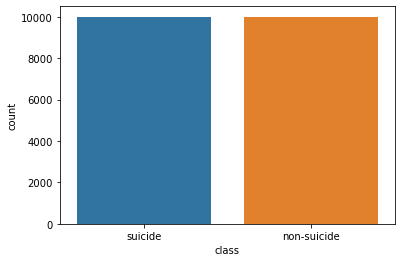

In [28]:
sns.countplot(df_preprocessed['class'])
plt.show()

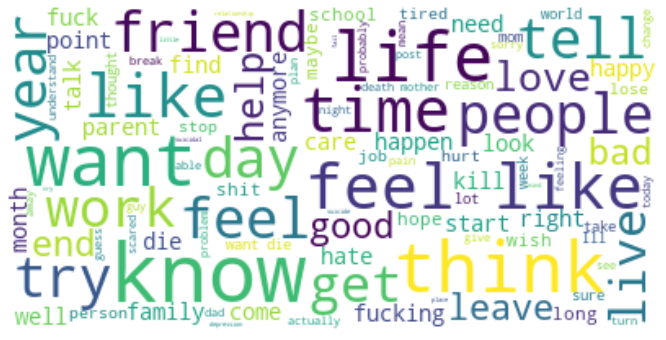

In [29]:
# Word clouds for suicide text
text = " ".join(text for text in suicide.text)
wordcloud = WordCloud(max_font_size=50, max_words=100, background_color="white",
                     stopwords = stopwords_set).generate(text)
fig = plt.figure(figsize = (20, 6)) 
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

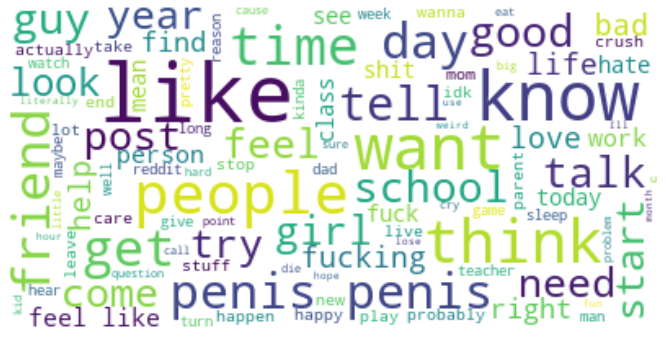

In [30]:
# Word clouds for non-suicide text
text = " ".join(text for text in non_suicide.text)
wordcloud = WordCloud(max_font_size=50, max_words=100, background_color="white",
                     stopwords = stopwords_set).generate(text)
fig = plt.figure(figsize = (20, 6)) 
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

In [31]:
## Apply unigram count vectorizer to suicide text
corpus_su_cv = unigram_count_vectorizer.fit_transform(corpus_su)
# Print length of the dictionaries to serve as a baseline. 
print("Count Vectorizer words in dictionary: %s" % len(unigram_count_vectorizer.get_feature_names()))

Count Vectorizer words in dictionary: 28497


In [32]:
## Get the column names
cols=unigram_count_vectorizer.get_feature_names()
print(cols[40:50])

['abilityexpertise', 'abiogenesis', 'abit', 'abiut', 'abject', 'ablation', 'able', 'ableism', 'ablitie', 'ablw']


In [33]:
## Convert it to an array
cvdf = pd.DataFrame(corpus_su_cv.toarray(), columns=cols)
# let's see top 20 frequency words after CountVectorizer
def get_top_n_words(corpus_su, n=None):
    vec = CountVectorizer(token_pattern=r'\b[^\d\W]+\b', stop_words=stopwords_set).fit(corpus_su)
    bag_of_words = vec.transform(corpus_su)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in     vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]
# Apply the function
get_top_n_words(corpus_su, n=20)

[('want', 13768),
 ('feel', 13260),
 ('like', 11868),
 ('know', 10791),
 ('life', 9988),
 ('think', 7804),
 ('time', 7366),
 ('people', 6533),
 ('year', 6424),
 ('friend', 6123),
 ('try', 5866),
 ('day', 5115),
 ('get', 5063),
 ('tell', 4907),
 ('live', 4744),
 ('help', 4690),
 ('kill', 4307),
 ('good', 4306),
 ('end', 4130),
 ('bad', 4038)]

In [34]:
## Apply unigram count vectorizer to un-suicide text
corpus_un_cv = unigram_count_vectorizer.fit_transform(corpus_un)
# Print length of the dictionaries to serve as a baseline. 
print("Count Vectorizer words in dictionary: %s" % len(unigram_count_vectorizer.get_feature_names()))

Count Vectorizer words in dictionary: 19806


In [35]:
## Get the column names
cols=unigram_count_vectorizer.get_feature_names()
print(cols[40:50])

['abandon', 'abandonment', 'abaut', 'abbreviate', 'abbreviation', 'abc', 'abcdefghijklmnopqrstuvwxyz', 'abd', 'abdicate', 'abduct']


In [36]:
## Convert it to an array
cvdf = pd.DataFrame(corpus_un_cv.toarray(), columns=cols)
# let's see top 20 frequency words after CountVectorizer
def get_top_n_words(corpus_un, n=None):
    vec = CountVectorizer(token_pattern=r'\b[^\d\W]+\b', stop_words=stopwords_set).fit(corpus_un)
    bag_of_words = vec.transform(corpus_un)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in     vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]
# Apply the function
get_top_n_words(corpus_un, n=20)

[('like', 4604),
 ('know', 2433),
 ('want', 2313),
 ('friend', 1924),
 ('people', 1897),
 ('think', 1863),
 ('feel', 1790),
 ('day', 1779),
 ('time', 1696),
 ('get', 1620),
 ('good', 1586),
 ('talk', 1357),
 ('penis', 1288),
 ('tell', 1269),
 ('school', 1267),
 ('year', 1209),
 ('girl', 1191),
 ('need', 1172),
 ('guy', 1147),
 ('post', 1136)]

# Modeling

## Multinomial Naive Baye's

In [37]:
NB = MultinomialNB()

# unigram cv set
NB.fit(X_uni_cv_train, y_train)
#Prediction on unigram cv train and test set
nb_uni_pre_train = NB.predict(X_uni_cv_train)
nb_uni_cv_train = accuracy_score(y_train,nb_uni_pre_train)
nb_uni_pre_test = NB.predict(X_uni_cv_test)
nb_uni_cv_test = accuracy_score(y_test,nb_uni_pre_test)

# bigram cv set
NB.fit(X_bi_cv_train, y_train)
#Prediction on unigram cv train and test set
nb_bi_pre_train = NB.predict(X_bi_cv_train)
nb_bi_cv_train = accuracy_score(y_train,nb_bi_pre_train)
nb_bi_pre_test = NB.predict(X_bi_cv_test)
nb_bi_cv_test = accuracy_score(y_test,nb_bi_pre_test)

# unigram cv (removed stopwords) set
NB.fit(X_uni_cv_st_train, y_train)
#Prediction on unigram cv train and test set
nb_uni_st_pre_train = NB.predict(X_uni_cv_st_train)
nb_uni_st_cv_train = accuracy_score(y_train,nb_uni_st_pre_train)
nb_uni_st_pre_test = NB.predict(X_uni_cv_st_test)
nb_uni_st_cv_test = accuracy_score(y_test,nb_uni_st_pre_test)

# bigram cv (removed stopwords) set
NB.fit(X_bi_cv_st_train, y_train)
#Prediction on unigram cv train and test set
nb_bi_st_pre_train = NB.predict(X_bi_cv_st_train)
nb_bi_st_cv_train = accuracy_score(y_train,nb_bi_st_pre_train)
nb_bi_st_pre_test = NB.predict(X_bi_cv_st_test)
nb_bi_st_cv_test = accuracy_score(y_test,nb_bi_st_pre_test)

In [38]:
nb_train_accuracy = pd.DataFrame(data=np.column_stack
                           ((nb_uni_cv_train, nb_bi_cv_train, nb_uni_st_cv_train, nb_bi_st_cv_train)), 
                           columns=['nb_uni_cv_train','nb_bi_cv_train','nb_uni_st_cv_train', 'nb_bi_st_cv_train'])

In [39]:
nb_train_accuracy

,nb_uni_cv_train,nb_bi_cv_train,nb_uni_st_cv_train,nb_bi_st_cv_train
0,0.907813,0.980313,0.909937,0.983563


In [40]:
nb_test_accuracy = pd.DataFrame(data=np.column_stack
                           ((nb_uni_cv_test, nb_bi_cv_test, nb_uni_st_cv_test, nb_bi_st_cv_test)), 
                           columns=['nb_uni_cv_test','nb_bi_cv_test','nb_uni_st_cv_test', 'nb_bi_st_cv_test'])

In [41]:
nb_test_accuracy

,nb_uni_cv_test,nb_bi_cv_test,nb_uni_st_cv_test,nb_bi_st_cv_test
0,0.868,0.73325,0.86775,0.73575


In [42]:
# unigram bv set
NB.fit(X_uni_bv_train, y_train)
#Prediction on unigram bv train and test set
nb_uni_pre_train = NB.predict(X_uni_bv_train)
nb_uni_bv_train = accuracy_score(y_train,nb_uni_pre_train)
nb_uni_pre_test = NB.predict(X_uni_bv_test)
nb_uni_bv_test = accuracy_score(y_test,nb_uni_pre_test)

# bigram cv set
NB.fit(X_bi_bv_train, y_train)
#Prediction on unigram cv train and test set
nb_bi_pre_train = NB.predict(X_bi_bv_train)
nb_bi_bv_train = accuracy_score(y_train,nb_bi_pre_train)
nb_bi_pre_test = NB.predict(X_bi_bv_test)
nb_bi_bv_test = accuracy_score(y_test,nb_bi_pre_test)

# unigram bv (removed stopwords) set
NB.fit(X_uni_bv_st_train, y_train)
#Prediction on unigram cv train and test set
nb_uni_st_pre_train = NB.predict(X_uni_bv_st_train)
nb_uni_st_bv_train = accuracy_score(y_train,nb_uni_st_pre_train)
nb_uni_st_pre_test = NB.predict(X_uni_bv_st_test)
nb_uni_st_bv_test = accuracy_score(y_test,nb_uni_st_pre_test)

# bigram bv (removed stopwords) set
NB.fit(X_bi_bv_st_train, y_train)
#Prediction on unigram cv train and test set
nb_bi_st_pre_train = NB.predict(X_bi_bv_st_train)
nb_bi_st_bv_train = accuracy_score(y_train,nb_bi_st_pre_train)
nb_bi_st_pre_test = NB.predict(X_bi_bv_st_test)
nb_bi_st_bv_test = accuracy_score(y_test,nb_bi_st_pre_test)

In [43]:
nb_test_accuracy_bool = pd.DataFrame(data=np.column_stack
                           ((nb_uni_bv_test, nb_bi_bv_test, nb_uni_st_bv_test, nb_bi_st_bv_test)), 
                           columns=['nb_uni_bv_test','nb_bi_bv_test','nb_uni_st_bv_test', 'nb_bi_st_bv_test'])

In [44]:
nb_test_accuracy_bool

,nb_uni_bv_test,nb_bi_bv_test,nb_uni_st_bv_test,nb_bi_st_bv_test
0,0.87625,0.73775,0.87625,0.73775


In [45]:
pd.concat([nb_test_accuracy, nb_test_accuracy_bool], axis=1)

,nb_uni_cv_test,nb_bi_cv_test,nb_uni_st_cv_test,nb_bi_st_cv_test,nb_uni_bv_test,nb_bi_bv_test,nb_uni_st_bv_test,nb_bi_st_bv_test
0,0.868,0.73325,0.86775,0.73575,0.87625,0.73775,0.87625,0.73775


In [46]:
NB.fit(unigram_bool_vectorizer.fit_transform(X_train), y_train)
#Prediction on train set
prediction = NB.predict(unigram_bool_vectorizer.transform(X_train))

In [47]:
#Confusion matrix
print(confusion_matrix(y_train, prediction))

[[6844 1130]
 [ 224 7802]]


In [48]:
#Classification Report
reportnb_cla = classification_report(y_train, prediction, output_dict=True)
dfnb_cla = pd.DataFrame(reportnb_cla).transpose()
dfnb_cla

,precision,recall,f1-score,support
non-suicide,0.968308,0.858289,0.909985,7974.000000
suicide,0.873489,0.972091,0.920156,8026.000000
accuracy,0.915375,0.915375,0.915375,0.915375
macro avg,0.920898,0.915190,0.915071,16000.000000
weighted avg,0.920744,0.915375,0.915087,16000.000000


In [49]:
#Prediction on test set
prediction_test = NB.predict(unigram_bool_vectorizer.transform(X_test))
#Confusion matrix
print(confusion_matrix(y_test, prediction_test))

[[1580  446]
 [  49 1925]]


In [50]:
#Evaluating on test data
reportnb = classification_report(y_test, prediction_test, output_dict=True)
dfnb = pd.DataFrame(reportnb).transpose()
dfnb

,precision,recall,f1-score,support
non-suicide,0.969920,0.779862,0.864569,2026.00000
suicide,0.811894,0.975177,0.886076,1974.00000
accuracy,0.876250,0.876250,0.876250,0.87625
macro avg,0.890907,0.877520,0.875323,4000.00000
weighted avg,0.891934,0.876250,0.875183,4000.00000


## SVMs

#### SVC with linear kernel

In [51]:
svclassifier = SVC(kernel='linear')
svclassifier.fit(unigram_count_vectorizer.fit_transform(X_train), y_train)

SVC(kernel='linear')

In [52]:
pred_svm_test = svclassifier.predict(unigram_count_vectorizer.transform(X_test))

In [53]:
print(confusion_matrix(y_test, pred_svm_test))
report = classification_report(y_test, pred_svm_test, output_dict=True)
dfsvmlinear = pd.DataFrame(report).transpose()

[[1849  177]
 [ 252 1722]]


In [54]:
dfsvmlinear

,precision,recall,f1-score,support
non-suicide,0.880057,0.912636,0.896050,2026.00000
suicide,0.906793,0.872340,0.889233,1974.00000
accuracy,0.892750,0.892750,0.892750,0.89275
macro avg,0.893425,0.892488,0.892642,4000.00000
weighted avg,0.893251,0.892750,0.892686,4000.00000


#### SVC with polynomial (degree 1) kernel

In [55]:
poly_svc = SVC(kernel='poly', degree=1)
poly_svc.fit(unigram_count_vectorizer.fit_transform(X_train), y_train)

SVC(degree=1, kernel='poly')

In [56]:
pred_svm_test = poly_svc.predict(unigram_count_vectorizer.transform(X_test))

In [57]:
print(confusion_matrix(y_test, pred_svm_test))
report = classification_report(y_test, pred_svm_test, output_dict=True)
dfsvmpoly = pd.DataFrame(report).transpose()

[[1920  106]
 [ 327 1647]]


In [58]:
dfsvmpoly

,precision,recall,f1-score,support
non-suicide,0.854473,0.947680,0.898666,2026.00000
suicide,0.939532,0.834347,0.883821,1974.00000
accuracy,0.891750,0.891750,0.891750,0.89175
macro avg,0.897002,0.891013,0.891243,4000.00000
weighted avg,0.896450,0.891750,0.891340,4000.00000


#### SVC with RBF kernel

In [59]:
rbf_svc = SVC(kernel='rbf')
rbf_svc.fit(unigram_count_vectorizer.fit_transform(X_train), y_train)

SVC()

In [60]:
pred_svm_test = rbf_svc.predict(unigram_count_vectorizer.transform(X_test))

In [61]:
print(confusion_matrix(y_test, pred_svm_test))
report = classification_report(y_test, pred_svm_test, output_dict=True)
dfsvmrbf = pd.DataFrame(report).transpose()

[[1894  132]
 [ 246 1728]]


In [62]:
dfsvmrbf

,precision,recall,f1-score,support
non-suicide,0.885047,0.934847,0.909265,2026.0000
suicide,0.929032,0.875380,0.901408,1974.0000
accuracy,0.905500,0.905500,0.905500,0.9055
macro avg,0.907039,0.905113,0.905337,4000.0000
weighted avg,0.906754,0.905500,0.905388,4000.0000


# Logistic Regression

In [63]:
logreg = LogisticRegression(solver='liblinear')

In [64]:
#Building Logistic Regression  Model
logreg.fit(unigram_count_vectorizer.fit_transform(X_train), y_train)

LogisticRegression(solver='liblinear')

In [65]:
#Prediction on train set
prediction_logistic = logreg.predict(unigram_count_vectorizer.transform(X_train))
#Confusion matrix
print(confusion_matrix(y_train, prediction_logistic))

[[7876   98]
 [ 271 7755]]


In [66]:
#classification_report
reportlog_cla = classification_report(y_train, prediction_logistic, output_dict=True)
dflog_cla = pd.DataFrame(reportlog_cla).transpose()
dflog_cla

,precision,recall,f1-score,support
non-suicide,0.966736,0.987710,0.977111,7974.000000
suicide,0.987521,0.966235,0.976762,8026.000000
accuracy,0.976938,0.976938,0.976938,0.976938
macro avg,0.977128,0.976972,0.976936,16000.000000
weighted avg,0.977162,0.976938,0.976936,16000.000000


In [67]:
#Evaluating on test data

prediction_logistic_test = logreg.predict(unigram_count_vectorizer.transform(X_test))
#Confusion matrix
print(confusion_matrix(y_test, prediction_logistic_test))
reportlog = classification_report(y_test, prediction_logistic_test, output_dict=True)
dflog = pd.DataFrame(reportlog).transpose()

[[1887  139]
 [ 211 1763]]


In [68]:
dflog

,precision,recall,f1-score,support
non-suicide,0.899428,0.931392,0.915131,2026.0000
suicide,0.926919,0.893110,0.909701,1974.0000
accuracy,0.912500,0.912500,0.912500,0.9125
macro avg,0.913174,0.912251,0.912416,4000.0000
weighted avg,0.912995,0.912500,0.912451,4000.0000


# Decision Tree classifier

In [69]:
## STEP 1   Create Training and Testing Data\
TrainDF, TestDF = train_test_split(Final_DF_Labeled, test_size=0.3)
# print(TrainDF)
# print(TestDF)

In [70]:
## STEP 2: Separate LABELS
## IMPORTANT - YOU CANNOT LEAVE LABELS ON
## Save labels

### TEST ---------------------
TestLabels=TestDF["LABEL"]
# print(TestLabels)
TestDF = TestDF.drop(["LABEL"], axis=1)
# print(TestDF)
### TRAIN----------------------
TrainLabels=TrainDF["LABEL"]
# print(TrainLabels)
## remove labels
TrainDF = TrainDF.drop(["LABEL"], axis=1)

In [71]:
label = ['suicide', 'un_suicide']

In [72]:
## Instantiate
MyDT = DecisionTreeClassifier(criterion='entropy', ##"entropy" or "gini"
                              splitter='best',  ## or "random" or "best"
                              max_depth=None,
                              min_samples_leaf=1,
                              min_weight_fraction_leaf=0.0,
                              max_features=None,
                              random_state=None,
                              max_leaf_nodes=None,
                              min_impurity_decrease=0.0,
                              class_weight=None)

##
MyDT.fit(TrainDF, TrainLabels)

#tree.plot_tree(MyDT)
#plt.savefig(temp1)

feature_names = TrainDF.columns
Tree_Object = tree.export_graphviz(MyDT, out_file=None,
                      ## The following creates TrainDF.columns for each
                      ## which are the feature names.
                      feature_names=feature_names,  
                      class_names=['class0', 'class1'],  # Define label names for classes
                      filled=True, rounded=True,  
                      special_characters=True)  

graph = graphviz.Source(Tree_Object, format='png', engine='dot')
   
graph.render("MyTree")


## Confusion Matrix
print("Prediction\n")
DT_pred = MyDT.predict(TestDF)
print(DT_pred)
   
bn_matrix = confusion_matrix(TestLabels, DT_pred)
print("\nThe confusion matrix is:")
print(bn_matrix)


FeatureImp = MyDT.feature_importances_  
indices = np.argsort(FeatureImp)[::-1]
## print out the important features.....
for f in range(TrainDF.shape[1]):
    if FeatureImp[indices[f]] > 0:
        print("%d. feature %d (%f)" % (f + 1, indices[f], FeatureImp[indices[f]]))
        print("feature name: ", feature_names[indices[f]])


dot: graph is too large for cairo-renderer bitmaps. Scaling by 0.487075 to fit


Prediction

['non-suicide' 'non-suicide' 'non-suicide' ... 'suicide' 'suicide'
 'non-suicide']

The confusion matrix is:
[[2503  522]
 [ 687 2288]]
1. feature 22 (0.197312)
feature name:  life
2. feature 19 (0.093434)
feature name:  kill
3. feature 8 (0.070917)
feature name:  feel
4. feature 39 (0.051630)
feature name:  suicide
5. feature 5 (0.032856)
feature name:  die
6. feature 46 (0.028827)
feature name:  want
7. feature 6 (0.027509)
feature name:  end
8. feature 0 (0.025834)
feature name:  anymore
9. feature 20 (0.021442)
feature name:  know
10. feature 23 (0.020837)
feature name:  like
11. feature 10 (0.017432)
feature name:  friend
12. feature 43 (0.016382)
feature name:  think
13. feature 42 (0.016112)
feature name:  tell
14. feature 24 (0.015485)
feature name:  live
15. feature 44 (0.014964)
feature name:  time
16. feature 17 (0.014947)
feature name:  help
17. feature 45 (0.014834)
feature name:  try
18. feature 14 (0.013839)
feature name:  good
19. feature 41 (0.013627)
featu

In [73]:
accuracy = accuracy_score(TestLabels,DT_pred)
reportdt = classification_report(TestLabels, DT_pred, output_dict=True)
dfdt = pd.DataFrame(reportdt).transpose()

In [74]:
print("DT Classification report:")
print("Accuracy: ", accuracy)
dfdt

DT Classification report:
Accuracy:  0.7985


,precision,recall,f1-score,support
non-suicide,0.784639,0.827438,0.805471,3025.0000
suicide,0.814235,0.769076,0.791011,2975.0000
accuracy,0.798500,0.798500,0.798500,0.7985
macro avg,0.799437,0.798257,0.798241,6000.0000
weighted avg,0.799314,0.798500,0.798301,6000.0000


# Random Forest

In [75]:
clf = RandomForestClassifier(max_depth=10)
clf.fit(TrainDF, TrainLabels)
y_predict_tfidf_2 = clf.predict(TestDF)

clf.fit(TrainDF, TrainLabels)
y_predict_tfidf_n12_2 = clf.predict(TestDF)

In [76]:
RandomForest_tfidf_results=metrics.precision_recall_fscore_support(TestLabels, y_predict_tfidf_2)
RandomForest_tfidf_n12_results=metrics.precision_recall_fscore_support(TestLabels, y_predict_tfidf_n12_2)

In [77]:
RandomForest_tfidf_acc= metrics.accuracy_score(TestLabels, y_predict_tfidf_2)
RandomForest_tfidf_n12_acc=metrics.accuracy_score(TestLabels, y_predict_tfidf_n12_2)

In [78]:
reportrf = classification_report(TestLabels, y_predict_tfidf_n12_2, output_dict=True)
dfrf = pd.DataFrame(reportdt).transpose()

In [79]:
dfrf

,precision,recall,f1-score,support
non-suicide,0.784639,0.827438,0.805471,3025.0000
suicide,0.814235,0.769076,0.791011,2975.0000
accuracy,0.798500,0.798500,0.798500,0.7985
macro avg,0.799437,0.798257,0.798241,6000.0000
weighted avg,0.799314,0.798500,0.798301,6000.0000


In [80]:
data2 = [['TF-IDF','TF-IDF 2-grams'],
         ['precision',RandomForest_tfidf_results[0][0],RandomForest_tfidf_n12_results[0][0]],
         ['recall',RandomForest_tfidf_results[1][0],RandomForest_tfidf_n12_results[1][0]],
         ['F1-score',RandomForest_tfidf_results[2][0],RandomForest_tfidf_n12_results[2][0]],
        ['accuracy',RandomForest_tfidf_acc,RandomForest_tfidf_n12_acc]]

In [81]:
print(tabulate(data2,headers='firstrow',tablefmt='fancy_grid'))

╒═══════════╤══════════╤══════════════════╕
│           │   TF-IDF │   TF-IDF 2-grams │
╞═══════════╪══════════╪══════════════════╡
│ precision │ 0.832919 │         0.833854 │
├───────────┼──────────┼──────────────────┤
│ recall    │ 0.886612 │         0.882645 │
├───────────┼──────────┼──────────────────┤
│ F1-score  │ 0.858927 │         0.857556 │
├───────────┼──────────┼──────────────────┤
│ accuracy  │ 0.853167 │         0.852167 │
╘═══════════╧══════════╧══════════════════╛


In [82]:
def plot_results(data):
    
    barWidth = 0.15
    # set heights of bars

    bars1 = [data[0][1],data[1][1], data[2][1]]
    bars2 = [data[0][2], data[1][2], data[2][2]]
    

    # Set position of bar on X axis
    r1 = np.arange(len(bars1))
    r2 = [x + barWidth for x in r1]
    

    # Make the plot
    plt.bar(r1, bars1, color='r', width=barWidth, edgecolor='white', label='tfidf')
    plt.bar(r2, bars2, color='b', width=barWidth, edgecolor='white', label='tfidf_n12')
    

    # Add xticks on the middle of the group bars
    plt.xlabel('group', fontweight='bold')
    plt.xticks([r + barWidth for r in range(len(bars1))], ['precision', 'recall', 'f1-score'])

    # Create legend & Show graphic
    plt.legend()
    plt.grid()
    plt.show()

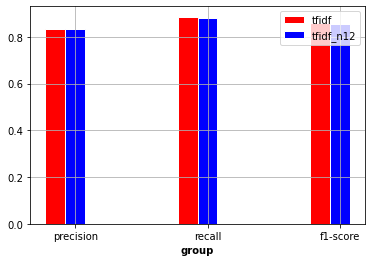

In [83]:
plot_results(data2[1:])